# Webscraping pour obtenir des informations sur les lieux des compétitions (Nombre de personnes allant à l'événement, Arrêts de métro à proximité, Lignes de métro)

In [15]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

Données disponibles sur le site https://www.paris2024.org

In [16]:

lieux = [
'stade-tour-eiffel',
'arena-champ-de-mars',
'grand-palais',
'invalides',
'pont-alexandre-iii',
'trocadero', 
'concorde',
'stade-roland-garros',
'arena-paris-sud', 
'arena-bercy', 
'arena-la-chapelle', 
'paris-la-defense-arena', 
'centre-aquatique', 
'stade-de-france',
'site-escalade-bourget',
'arena-paris-nord'
]

urls = [
    f"https://www.paris2024.org/fr/site/{lieu.replace(' ', '-').lower()}/" for lieu in lieux
]

Extraction des informations sur les lieux des compétitions : capacité, stations de métro à proximité et lignes de métro pour y aller

In [17]:
def get_specific_lines(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        specific_lines = {
            'Capacité': [],
            'Stations': []  # Création d'une liste pour stocker les stations
        }
        for paragraph in soup.find_all('p'):
            # Recherche des lignes contenant les Capacité spécifiques
            if ('Capacité' in paragraph.text or 
                'Capacité court Philippe-Chatrier' in paragraph.text or 
                'Volleyball' in paragraph.text or 
                'Pour la gymnastique rythmique' in paragraph.text):
                specific_lines['Capacité'].append(paragraph.text.strip())
                
            # Extraction des phrases après "desservie" ou "desservi"
            if 'desservie' in paragraph.text or 'desservi' in paragraph.text:
                sentences = paragraph.text.split('.')  # Séparation en phrases
                for sentence in sentences:
                    if 'desservie' in sentence or 'desservi' in sentence:
                        specific_lines['Stations'].append(sentence.strip())
        
        return specific_lines
    return None


# Création d'un dictionnaire pour stocker les résultats
results = {lieu: get_specific_lines(url) for lieu, url in zip(lieux, urls)}
# Création d'un DataFrame à partir du dictionnaire
df = pd.DataFrame(results.items(), columns=['Lieu', 'Infos'])
# Expansion du dictionnaire pour créer les colonnes 'Capacité' et 'Stations'
df = pd.concat([df.drop(['Infos'], axis=1), df['Infos'].apply(pd.Series)], axis=1)

display(df)

,Lieu,Capacité,Stations
0,stade-tour-eiffel,[Capacité : 12 860 spectateurs],[Le Stade Tour Eiffel sera desservi par les ga...
1,arena-champ-de-mars,[Capacité : 8 356 places],[L’Arena Champ de Mars sera desservie par la g...
2,grand-palais,[Capacité : 8 000 personnes pendant les Jeux O...,[Le Grand Palais sera desservi par la station ...
3,invalides,[Capacité : 8 000 places],[Le site des Invalides sera desservi par la ga...
4,pont-alexandre-iii,[Capacité : 1 000 personnes],[Le site du Pont Alexandre III sera desservi p...
5,trocadero,[Capacité : 3 349 places],[Le site du Trocadéro sera desservi par la sta...
6,concorde,[],[Le site de La Concorde sera desservi par les ...
7,stade-roland-garros,[Capacité court Philippe-Chatrier : 14 962 pla...,[Le Stade Roland Garros sera desservi par les ...
8,arena-paris-sud,[],[L’Arena Paris Sud sera desservie par les stat...
9,arena-bercy,[Capacité : 15 000 spectateurs.],[L’Arena Bercy sera desservie par la station «...


Compléter pour les données manquantes : Concorde (données disponibles sur le site : https://sportetsociete.org/2022/10/20/paris-2024-un-cadre-majestueux-pour-louverture-des-jeux-paralympiques)

In [18]:
# Faites une requête GET pour récupérer le contenu HTML de la page
url = 'https://sportetsociete.org/2022/10/20/paris-2024-un-cadre-majestueux-pour-louverture-des-jeux-paralympiques'
response = requests.get(url)

# Vérifiez si la requête a réussi
if response.status_code == 200:
    # Utilisation de BeautifulSoup pour analyser le contenu HTML
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Recherchez le texte contenant "places"
    texte_places = soup.find(text=lambda text: text and "places" in text)

    if texte_places:
        # Imprimez le texte trouvé
        df.iloc[6, 1]=texte_places.strip()

/tmp/ipykernel_32558/1771775837.py:11: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  texte_places = soup.find(text=lambda text: text and "places" in text)


Compléter pour les données manquantes : Arena Paris Sud (données disponible sur le site : https://fr.wikipedia.org/wiki/Arena_Porte_de_la_Chapelle)

In [19]:
#Compléter pour les valeurs manquantes : arena-paris-sud
url = "https://fr.wikipedia.org/wiki/Arena_Porte_de_la_Chapelle"

# Obtenir le contenu de la page
response = requests.get(url)

if response.status_code == 200:
    # Analyser le contenu HTML avec BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    # Trouver le texte de la ligne commençant par "Capacité"
    capacity_text = soup.find("th", text="Capacité").find_next("td").get_text(strip=True)

    # Mettre à jour la case correspondante dans le DataFrame df
    df.iloc[8, 1] = capacity_text  # Ligne 8, colonne 2, indexées à partir de 0

else:
    print("La requête a échoué")

display(df)

/tmp/ipykernel_32558/260701026.py:12: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  capacity_text = soup.find("th", text="Capacité").find_next("td").get_text(strip=True)


,Lieu,Capacité,Stations
0,stade-tour-eiffel,[Capacité : 12 860 spectateurs],[Le Stade Tour Eiffel sera desservi par les ga...
1,arena-champ-de-mars,[Capacité : 8 356 places],[L’Arena Champ de Mars sera desservie par la g...
2,grand-palais,[Capacité : 8 000 personnes pendant les Jeux O...,[Le Grand Palais sera desservi par la station ...
3,invalides,[Capacité : 8 000 places],[Le site des Invalides sera desservi par la ga...
4,pont-alexandre-iii,[Capacité : 1 000 personnes],[Le site du Pont Alexandre III sera desservi p...
5,trocadero,[Capacité : 3 349 places],[Le site du Trocadéro sera desservi par la sta...
6,concorde,Des tribunes de 35 000 places seront alors age...,[Le site de La Concorde sera desservi par les ...
7,stade-roland-garros,[Capacité court Philippe-Chatrier : 14 962 pla...,[Le Stade Roland Garros sera desservi par les ...
8,arena-paris-sud,9 000 (maximum),[L’Arena Paris Sud sera desservie par les stat...
9,arena-bercy,[Capacité : 15 000 spectateurs.],[L’Arena Bercy sera desservie par la station «...


In [20]:
def extraire_nombres(texte):
    nombres = re.findall(r'[-+]?\d*\.\d+|\d+', str(texte))  # Expression régulière pour les nombres entiers ou décimaux
    return ' '.join(nombres)  # Retourne les nombres extraits sous forme d'une chaîne séparée par des espaces

# Appliquer la fonction sur la colonne 'Capacité'
df['Nombre de personnes à l\'événément'] = df['Capacité'].apply(extraire_nombres)

# Supposons que 'df' est votre DataFrame contenant la colonne 'Nombres'

# Remplacer "202" par une chaîne vide dans la colonne 'Nombre de personnes à l\'événément'
df['Nombre de personnes à l\'événément'] = df['Nombre de personnes à l\'événément'].str.replace('202', '')

# Supprimer les espaces dans la colonne 'NNombre de personnes à l\'événément'
df['Nombre de personnes à l\'événément'] = df['Nombre de personnes à l\'événément'].str.replace(' ', '')

# Supposons que 'df' est votre DataFrame contenant la colonne 'Nombres'

# Remplacer les valeurs dans la colonne 'Nombres' aux lignes spécifiques
df.loc[2, 'Nombre de personnes à l\'événément'] = '8000'  # Remplacer la deuxième ligne par '8000'
df.loc[10, 'Nombre de personnes à l\'événément'] = '6700'  # Remplacer la 10ème ligne par '6700'
df.loc[14, 'Nombre de personnes à l\'événément'] = '6000'  # Remplacer la 14ème ligne par '6000'

# Fonction pour supprimer le zéro en tête des nombres
def remove_leading_zero(number):
    if number.startswith('0'):
        return number[1:]
    return number

# Appliquer la fonction à la colonne 'Nombres' pour supprimer les zéros en tête
df['Nombre de personnes à l\'événément'] = df['Nombre de personnes à l\'événément'].astype(str).apply(remove_leading_zero)

display(df)

,Lieu,Capacité,Stations,Nombre de personnes à l'événément
0,stade-tour-eiffel,[Capacité : 12 860 spectateurs],[Le Stade Tour Eiffel sera desservi par les ga...,12860
1,arena-champ-de-mars,[Capacité : 8 356 places],[L’Arena Champ de Mars sera desservie par la g...,8356
2,grand-palais,[Capacité : 8 000 personnes pendant les Jeux O...,[Le Grand Palais sera desservi par la station ...,8000
3,invalides,[Capacité : 8 000 places],[Le site des Invalides sera desservi par la ga...,8000
4,pont-alexandre-iii,[Capacité : 1 000 personnes],[Le site du Pont Alexandre III sera desservi p...,1000
5,trocadero,[Capacité : 3 349 places],[Le site du Trocadéro sera desservi par la sta...,3349
6,concorde,Des tribunes de 35 000 places seront alors age...,[Le site de La Concorde sera desservi par les ...,35000
7,stade-roland-garros,[Capacité court Philippe-Chatrier : 14 962 pla...,[Le Stade Roland Garros sera desservi par les ...,14962
8,arena-paris-sud,9 000 (maximum),[L’Arena Paris Sud sera desservie par les stat...,9000
9,arena-bercy,[Capacité : 15 000 spectateurs.],[L’Arena Bercy sera desservie par la station «...,15000


Lire chaque ligne de la colonne 'Stations'

In [21]:
for index, station in df['Stations'].items():
    print(station)

['Le Stade Tour Eiffel sera desservi par les gares «\xa0Champ de Mars Tour Eiffel\xa0» et «\xa0Pont de l’Alma\xa0» (RER C), par la station «\xa0Bir Hakeim\xa0» (Métro 6), et par la station «\xa0Alma Marceau\xa0» (Métro 9)']
['L’Arena Champ de Mars sera desservie par la gare «\xa0Champ de Mars Tour Eiffel\xa0» (RER C), la station «\xa0La Motte Piquet Grenelle\xa0» (Métro 6, Métro 8), et la station «\xa0Ségur\xa0» (Métro 10)']
['Le Grand Palais sera desservi par la station «\xa0Franklin D']
['Le site des Invalides sera desservi par la gare «\xa0Invalides\xa0» (RER C, Métro 8, Métro 13)']
['Le site du Pont Alexandre III sera desservi par la gare «\xa0Invalides\xa0» (RER C, Métro 8, Métro 13)']
['Le site du Trocadéro sera desservi par la station «\xa0Iéna\xa0» (Métro 9), la station Trocadéro (Métro 6 et 9) et la gare «\xa0Pont de l’Alma\xa0» (RER C)']
['Le site de La Concorde sera desservi par les stations «\xa0Palais Royal – Musée du Louvre\xa0» (Métro 1, Métro 7), «\xa0Madeleine\xa0» (Mé

Réécriture à la main des arrêts à partir du texte du dessus et remplacement par des x les endroits inacessibles par métro 

In [22]:
arrêts=[['BIR HAKEIM', 'ALMA MARCEAU'],
        ['LA MOTTE-PICQUET-GRENELLE', 'LA MOTTE-PICQUET-GRENELLE', 'SEGUR'], 
        ['FRANKLIN D. ROOSEVELT', 'FRANKLIN D. ROOSEVELT'], 
        ['INVALIDES'], 
        ['INVALIDES'],
        ['IENA','TROCADERO'], 
        ['PALAIS-ROYAL','PALAIS-ROYAL','MADELEINE', 'MADELEINE', 'MADELEINE', 'OPERA'],
        ['PORTE DE SAINT-CLOUD','PORTE D\'AUTEUIL'], 
        ['PORTE DE VERSAILLES','BALARD','PORTE DE VANVES'], 
        ['BERCY','BERCY','GARE DE LYON'],
        ['PORTE DE LA CHAPELLE'],
        ['LA DEFENSE'],
        ['x'],
        ['SAINT-DENIS-PORTE DE PARIS'], 
        ['x'],
        ['x']]
 
df['Arrêts']=arrêts

Extraiction des numéros de ligne pour chaque lieu de compétition et remplissage à la main pour Frankin D (pas d'info sur le site)

In [23]:
# Fonction pour extraire les nombres après le mot "Métro"
def extract_numbers(text):
    matches = re.findall(r'Métro\s+(\d+)', str(text), flags=re.IGNORECASE)
    return matches

# Appliquer la fonction à la colonne 'Stations' pour créer une nouvelle colonne 'Nombres après Métro'
df['Lignes'] = df['Stations'].apply(extract_numbers)

# Compléter pour Franklin D
df.at[2, 'Lignes'] = [6, 9]

Mise au propre du tableau et mise en avant de certaines données utiles 

In [24]:
# Supprimer les colonnes 'Capacité' et 'Stations'
colonnes_a_supprimer = ['Capacité', 'Stations']
df = df.drop(colonnes_a_supprimer, axis=1)

# Calculer le nombre d'éléments dans chaque vecteur de la ligne 'Lignes'
df['Nombre de lignes'] = df['Lignes'].apply(lambda x: len(x) if isinstance(x, list) else None)

# Convertir la colonne 'Nombre de personnes à l\'événément' en type numérique (int ou float)
df['Nombre de personnes à l\'événément'] = pd.to_numeric(df['Nombre de personnes à l\'événément'], errors='coerce')

# Créer la nouvelle colonne en calculant la division
df['Nombre de personnes par ligne'] = df['Nombre de personnes à l\'événément'] / df['Nombre de lignes']

# Définir l'option d'affichage pour éviter la notation scientifique
pd.set_option('display.float_format', lambda x: '%.2f' % x)

nombre_personnes = df.pop('Nombre de personnes par ligne')
df.insert(2, 'Nombre de personnes par ligne', nombre_personnes)

Suppression des lieux qui ne sont pas accessibles par métro

In [25]:
# Identifier les indices des lignes contenant les valeurs spécifiques dans la colonne 'lieu'
indices_a_supprimer = df[df['Lieu'].isin(['centre-aquatique', 'site-escalade-bourget', 'arena-paris-nord'])].index

# Supprimer les lignes correspondantes
df = df.drop(indices_a_supprimer)

display(df)

,Lieu,Nombre de personnes à l'événément,Nombre de personnes par ligne,Arrêts,Lignes,Nombre de lignes
0,stade-tour-eiffel,12860,6430.00,"[BIR HAKEIM, ALMA MARCEAU]","[6, 9]",2
1,arena-champ-de-mars,8356,2785.33,"[LA MOTTE-PICQUET-GRENELLE, LA MOTTE-PICQUET-G...","[6, 8, 10]",3
2,grand-palais,8000,4000.00,"[FRANKLIN D. ROOSEVELT, FRANKLIN D. ROOSEVELT]","[6, 9]",2
3,invalides,8000,4000.00,[INVALIDES],"[8, 13]",2
4,pont-alexandre-iii,1000,500.00,[INVALIDES],"[8, 13]",2
5,trocadero,3349,1674.50,"[IENA, TROCADERO]","[9, 6]",2
6,concorde,35000,5833.33,"[PALAIS-ROYAL, PALAIS-ROYAL, MADELEINE, MADELE...","[1, 7, 8, 12, 14, 3]",6
7,stade-roland-garros,14962,7481.00,"[PORTE DE SAINT-CLOUD, PORTE D'AUTEUIL]","[9, 10]",2
8,arena-paris-sud,9000,3000.00,"[PORTE DE VERSAILLES, BALARD, PORTE DE VANVES]","[12, 8, 13]",3
9,arena-bercy,15000,5000.00,"[BERCY, BERCY, GARE DE LYON]","[6, 14, 1]",3


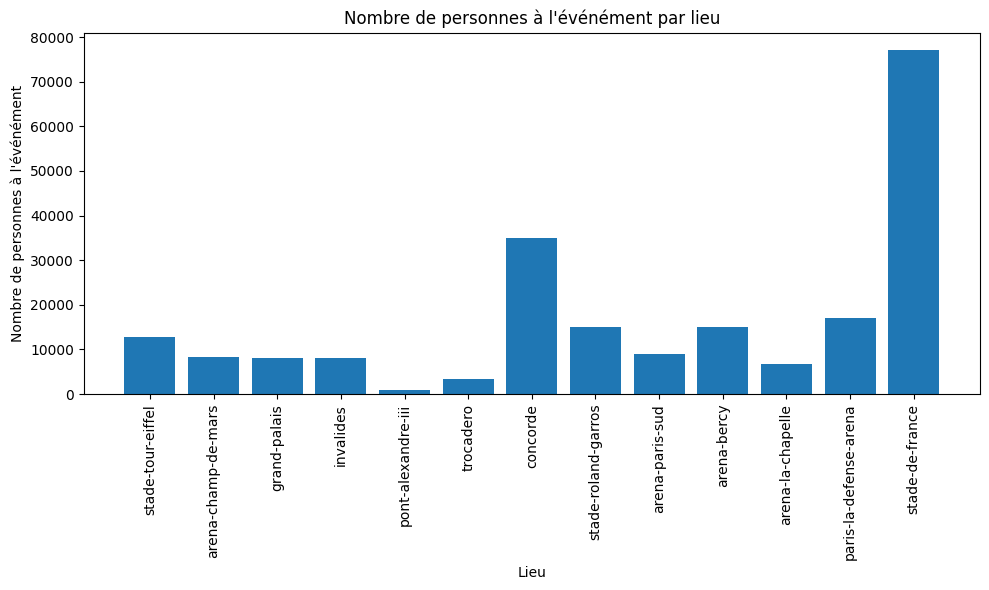

In [26]:
import matplotlib.pyplot as plt

# Diagramme à barres du nombre de personnes par lieu
plt.figure(figsize=(10, 6))
plt.bar(df['Lieu'], df['Nombre de personnes à l\'événément'])
plt.xticks(rotation=90)
plt.xlabel('Lieu')
plt.ylabel('Nombre de personnes à l\'événément')
plt.title('Nombre de personnes à l\'événément par lieu')
plt.tight_layout()
plt.show()

In [27]:
# Votre DataFrame existant
# Supposons que votre DataFrame s'appelle df et contient les informations que vous avez fournies précédemment.

# Créer un DataFrame avec des lignes individuelles pour chaque élément de la liste
df_exploded = df.explode('Lignes')

# Conversion de la colonne 'Lignes' en type numérique si elle est de type string
df_exploded['Lignes'] = pd.to_numeric(df_exploded['Lignes'])

# Calcul des statistiques descriptives par numéro de ligne
stats_par_ligne = df_exploded.groupby('Lignes').agg({
    'Nombre de personnes à l\'événément': ['mean', 'median', 'min', 'max', 'std'],
    'Nombre de lignes': 'count'  # Compter le nombre de lieux par numéro de ligne
})
